In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_fusion'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 785.17it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
       
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
        
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
            
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:10<00:00, 33.58img/s]

***
ensemble_fusion Loss: 1.182639479637146


Epoch 1/50:  99%|█████████▊| 200/203 [00:13<00:00, 15.35img/s]


---
ensemble_fusion Validation Dice Loss: 1.4431754350662231
ensemble_fusion Validation Pixel Accuracy: 0.14941379480194628
ensemble_fusion Validation MIoU: 0.07470689740097317
ensemble_fusion Validation Dice Score: 0.28675708174705505


Epoch 2/50:  99%|█████████▊| 200/203 [00:09<00:00, 33.48img/s]

***
ensemble_fusion Loss: 0.8449218273162842


Epoch 2/50:  99%|█████████▊| 200/203 [00:12<00:00, 16.28img/s]


---
ensemble_fusion Validation Dice Loss: 1.4584977626800537
ensemble_fusion Validation Pixel Accuracy: 0.3128865559895833
ensemble_fusion Validation MIoU: 0.18540004176263347
ensemble_fusion Validation Dice Score: 0.33782491087913513


Epoch 3/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.42img/s]

***
ensemble_fusion Loss: 0.6595375537872314


Epoch 3/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.79img/s]


---
ensemble_fusion Validation Dice Loss: 0.9747397303581238
ensemble_fusion Validation Pixel Accuracy: 0.7859092846251371
ensemble_fusion Validation MIoU: 0.578381092580101
ensemble_fusion Validation Dice Score: 0.6249225735664368


Epoch 4/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.25img/s]

***
ensemble_fusion Loss: 0.5522005558013916


Epoch 4/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.38img/s]


---
ensemble_fusion Validation Dice Loss: 0.6743441820144653
ensemble_fusion Validation Pixel Accuracy: 0.90870720043517
ensemble_fusion Validation MIoU: 0.7535708336128734
ensemble_fusion Validation Dice Score: 0.7629826664924622


Epoch 5/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.33img/s]

***
ensemble_fusion Loss: 0.5265803337097168


Epoch 5/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.28img/s]


---
ensemble_fusion Validation Dice Loss: 0.5739243626594543
ensemble_fusion Validation Pixel Accuracy: 0.9281766121847588
ensemble_fusion Validation MIoU: 0.7829813376142687
ensemble_fusion Validation Dice Score: 0.7839462161064148


Epoch 6/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.64img/s]

***
ensemble_fusion Loss: 0.4694367051124573


Epoch 6/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.49img/s]


---
ensemble_fusion Validation Dice Loss: 0.5306241512298584
ensemble_fusion Validation Pixel Accuracy: 0.9374263830352247
ensemble_fusion Validation MIoU: 0.811551979587338
ensemble_fusion Validation Dice Score: 0.8247820138931274


Epoch 7/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.11img/s]

***
ensemble_fusion Loss: 0.44059738516807556


Epoch 7/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.88img/s]


---
ensemble_fusion Validation Dice Loss: 0.5671411752700806
ensemble_fusion Validation Pixel Accuracy: 0.9306790535910088
ensemble_fusion Validation MIoU: 0.7984126538296525
ensemble_fusion Validation Dice Score: 0.8041065335273743


Epoch 8/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.16img/s]

***
ensemble_fusion Loss: 0.3428272604942322


Epoch 8/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.28img/s]


---
ensemble_fusion Validation Dice Loss: 0.46723222732543945
ensemble_fusion Validation Pixel Accuracy: 0.9384511311848959
ensemble_fusion Validation MIoU: 0.8130130165686429
ensemble_fusion Validation Dice Score: 0.8069809079170227


Epoch 9/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.13img/s]

***
ensemble_fusion Loss: 0.39828023314476013


Epoch 9/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.44img/s]


---
ensemble_fusion Validation Dice Loss: 0.407132625579834
ensemble_fusion Validation Pixel Accuracy: 0.9541510866399396
ensemble_fusion Validation MIoU: 0.8510963906269122
ensemble_fusion Validation Dice Score: 0.85357666015625


Epoch 10/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.33img/s]

***
ensemble_fusion Loss: 0.2972032129764557


Epoch 10/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.80img/s]


---
ensemble_fusion Validation Dice Loss: 0.37638676166534424
ensemble_fusion Validation Pixel Accuracy: 0.9606374104817709
ensemble_fusion Validation MIoU: 0.8685175299104875
ensemble_fusion Validation Dice Score: 0.8747327923774719


Epoch 11/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.95img/s]

***
ensemble_fusion Loss: 0.25896862149238586


Epoch 11/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.02img/s]


---
ensemble_fusion Validation Dice Loss: 0.39069998264312744
ensemble_fusion Validation Pixel Accuracy: 0.950292754591557
ensemble_fusion Validation MIoU: 0.8425145283215899
ensemble_fusion Validation Dice Score: 0.8703427314758301


Epoch 12/50:  99%|█████████▊| 200/203 [00:07<00:00, 32.99img/s]

***
ensemble_fusion Loss: 0.2872818112373352


Epoch 12/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.49img/s]


---
ensemble_fusion Validation Dice Loss: 0.3539939820766449
ensemble_fusion Validation Pixel Accuracy: 0.9471119663171601
ensemble_fusion Validation MIoU: 0.8338979212523252
ensemble_fusion Validation Dice Score: 0.871317982673645


Epoch 13/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.02img/s]

***
ensemble_fusion Loss: 0.29204457998275757


Epoch 13/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.29img/s]


---
ensemble_fusion Validation Dice Loss: 0.29497817158699036
ensemble_fusion Validation Pixel Accuracy: 0.9575816371984649
ensemble_fusion Validation MIoU: 0.8579141269204067
ensemble_fusion Validation Dice Score: 0.8909285664558411


Epoch 14/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.98img/s]

***
ensemble_fusion Loss: 0.253389447927475


Epoch 14/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.16img/s]


---
ensemble_fusion Validation Dice Loss: 0.23054252564907074
ensemble_fusion Validation Pixel Accuracy: 0.9714872125993695
ensemble_fusion Validation MIoU: 0.9000774387150196
ensemble_fusion Validation Dice Score: 0.8965649008750916


Epoch 15/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.79img/s]

***
ensemble_fusion Loss: 0.17817820608615875


Epoch 15/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.52img/s]


---
ensemble_fusion Validation Dice Loss: 0.20404860377311707
ensemble_fusion Validation Pixel Accuracy: 0.9685379831414473
ensemble_fusion Validation MIoU: 0.8814923309144684
ensemble_fusion Validation Dice Score: 0.8733966946601868


Epoch 16/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.03img/s]

***
ensemble_fusion Loss: 0.1319756805896759


Epoch 16/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.13img/s]


---
ensemble_fusion Validation Dice Loss: 0.25907742977142334
ensemble_fusion Validation Pixel Accuracy: 0.9570545397306743
ensemble_fusion Validation MIoU: 0.8590995334472113
ensemble_fusion Validation Dice Score: 0.8926857113838196


Epoch 17/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.94img/s]

***
ensemble_fusion Loss: 0.12431465089321136


Epoch 17/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.83img/s]


---
ensemble_fusion Validation Dice Loss: 0.1666879653930664
ensemble_fusion Validation Pixel Accuracy: 0.9763544986122533
ensemble_fusion Validation MIoU: 0.9146375054696038
ensemble_fusion Validation Dice Score: 0.9096212387084961


Epoch 18/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.07img/s]

***
ensemble_fusion Loss: 0.1703665554523468


Epoch 18/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.19img/s]


---
ensemble_fusion Validation Dice Loss: 0.21876099705696106
ensemble_fusion Validation Pixel Accuracy: 0.9654193008155153
ensemble_fusion Validation MIoU: 0.8832250215956328
ensemble_fusion Validation Dice Score: 0.8956089019775391


Epoch 19/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.93img/s]

***
ensemble_fusion Loss: 0.13164235651493073


Epoch 19/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.12img/s]


---
ensemble_fusion Validation Dice Loss: 0.17615598440170288
ensemble_fusion Validation Pixel Accuracy: 0.9709001507675439
ensemble_fusion Validation MIoU: 0.8986488845229613
ensemble_fusion Validation Dice Score: 0.9171854257583618


Epoch 20/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.12img/s]

***
ensemble_fusion Loss: 0.16578525304794312


Epoch 20/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.09img/s]


---
ensemble_fusion Validation Dice Loss: 0.13059476017951965
ensemble_fusion Validation Pixel Accuracy: 0.9793623539439419
ensemble_fusion Validation MIoU: 0.9240615768228028
ensemble_fusion Validation Dice Score: 0.9234089851379395


Epoch 21/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.23img/s]

***
ensemble_fusion Loss: 0.09008772671222687


Epoch 21/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.86img/s]


---
ensemble_fusion Validation Dice Loss: 0.1653163880109787
ensemble_fusion Validation Pixel Accuracy: 0.968530487595943
ensemble_fusion Validation MIoU: 0.8923438065198974
ensemble_fusion Validation Dice Score: 0.9173083305358887


Epoch 22/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.14img/s]

***
ensemble_fusion Loss: 0.10635501891374588


Epoch 22/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.53img/s]


---
ensemble_fusion Validation Dice Loss: 0.11092658340930939
ensemble_fusion Validation Pixel Accuracy: 0.9810108385587993
ensemble_fusion Validation MIoU: 0.9281106602491507
ensemble_fusion Validation Dice Score: 0.9209849238395691


Epoch 23/50:  99%|█████████▊| 200/203 [00:07<00:00, 33.15img/s]

***
ensemble_fusion Loss: 0.07351054251194


Epoch 23/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.59img/s]


---
ensemble_fusion Validation Dice Loss: 0.138854518532753
ensemble_fusion Validation Pixel Accuracy: 0.9714055646929824
ensemble_fusion Validation MIoU: 0.8988260690597196
ensemble_fusion Validation Dice Score: 0.9167450070381165


Epoch 24/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.08img/s]

***
ensemble_fusion Loss: 0.07422865927219391


Epoch 24/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.78img/s]


---
ensemble_fusion Validation Dice Loss: 0.14366251230239868
ensemble_fusion Validation Pixel Accuracy: 0.9710115131578947
ensemble_fusion Validation MIoU: 0.8989731660306579
ensemble_fusion Validation Dice Score: 0.920737087726593


Epoch 25/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.00img/s]

***
ensemble_fusion Loss: 0.06991302967071533


Epoch 25/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.00img/s]


---
ensemble_fusion Validation Dice Loss: 0.12105249613523483
ensemble_fusion Validation Pixel Accuracy: 0.976565444678591
ensemble_fusion Validation MIoU: 0.9158356188572089
ensemble_fusion Validation Dice Score: 0.9276191592216492


Epoch 26/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.05img/s]

***
ensemble_fusion Loss: 0.06529751420021057


Epoch 26/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.48img/s]


---
ensemble_fusion Validation Dice Loss: 0.1274648904800415
ensemble_fusion Validation Pixel Accuracy: 0.9761373954906798
ensemble_fusion Validation MIoU: 0.9147059238090275
ensemble_fusion Validation Dice Score: 0.9262725710868835


Epoch 27/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.99img/s]

***
ensemble_fusion Loss: 0.06600230932235718


Epoch 27/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.02img/s]


---
ensemble_fusion Validation Dice Loss: 0.1157011017203331
ensemble_fusion Validation Pixel Accuracy: 0.9782920971251371
ensemble_fusion Validation MIoU: 0.9215416954884408
ensemble_fusion Validation Dice Score: 0.928243100643158


Epoch 28/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.06img/s]

***
ensemble_fusion Loss: 0.06953027844429016


Epoch 28/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.21img/s]


---
ensemble_fusion Validation Dice Loss: 0.11514467000961304
ensemble_fusion Validation Pixel Accuracy: 0.9786079808285362
ensemble_fusion Validation MIoU: 0.9223746790355272
ensemble_fusion Validation Dice Score: 0.9312637448310852


Epoch 29/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.97img/s]

***
ensemble_fusion Loss: 0.05745182931423187


Epoch 29/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.89img/s]


---
ensemble_fusion Validation Dice Loss: 0.11717469245195389
ensemble_fusion Validation Pixel Accuracy: 0.9775845711691338
ensemble_fusion Validation MIoU: 0.9191835667774664
ensemble_fusion Validation Dice Score: 0.9297957420349121


Epoch 30/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.11img/s]

***
ensemble_fusion Loss: 0.06237621232867241


Epoch 30/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.22img/s]


---
ensemble_fusion Validation Dice Loss: 0.11710157990455627
ensemble_fusion Validation Pixel Accuracy: 0.9777334112870065
ensemble_fusion Validation MIoU: 0.9198044920524431
ensemble_fusion Validation Dice Score: 0.9308695197105408


Epoch 31/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.03img/s]

***
ensemble_fusion Loss: 0.05912325531244278


Epoch 31/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.97img/s]


---
ensemble_fusion Validation Dice Loss: 0.12222658097743988
ensemble_fusion Validation Pixel Accuracy: 0.9768248440926535
ensemble_fusion Validation MIoU: 0.9168541139920088
ensemble_fusion Validation Dice Score: 0.9305229187011719


Epoch 32/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.05img/s]

***
ensemble_fusion Loss: 0.06408487260341644


Epoch 32/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.10img/s]


---
ensemble_fusion Validation Dice Loss: 0.1294187754392624
ensemble_fusion Validation Pixel Accuracy: 0.9744835569147479
ensemble_fusion Validation MIoU: 0.9095422238637383
ensemble_fusion Validation Dice Score: 0.9285452961921692


Epoch 33/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.05img/s]

***
ensemble_fusion Loss: 0.056632205843925476


Epoch 33/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.38img/s]


---
ensemble_fusion Validation Dice Loss: 0.12310745567083359
ensemble_fusion Validation Pixel Accuracy: 0.9762616073876097
ensemble_fusion Validation MIoU: 0.9148535180184469
ensemble_fusion Validation Dice Score: 0.930371105670929


Epoch 34/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.05img/s]

***
ensemble_fusion Loss: 0.0663381814956665


Epoch 34/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.99img/s]


---
ensemble_fusion Validation Dice Loss: 0.12489580363035202
ensemble_fusion Validation Pixel Accuracy: 0.9757768062123081
ensemble_fusion Validation MIoU: 0.9135018980106514
ensemble_fusion Validation Dice Score: 0.9297089576721191


Epoch 35/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.06img/s]

***
ensemble_fusion Loss: 0.058466047048568726


Epoch 35/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.97img/s]


---
ensemble_fusion Validation Dice Loss: 0.12217013537883759
ensemble_fusion Validation Pixel Accuracy: 0.9766283537212171
ensemble_fusion Validation MIoU: 0.9161177154503697
ensemble_fusion Validation Dice Score: 0.930877149105072


Epoch 36/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.98img/s]

***
ensemble_fusion Loss: 0.05574940890073776


Epoch 36/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.17img/s]


---
ensemble_fusion Validation Dice Loss: 0.12142408639192581
ensemble_fusion Validation Pixel Accuracy: 0.9762476870888158
ensemble_fusion Validation MIoU: 0.9147449151267174
ensemble_fusion Validation Dice Score: 0.9305692911148071


Epoch 37/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.94img/s]

***
ensemble_fusion Loss: 0.06186017766594887


Epoch 37/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.75img/s]


---
ensemble_fusion Validation Dice Loss: 0.12772804498672485
ensemble_fusion Validation Pixel Accuracy: 0.974942123680784
ensemble_fusion Validation MIoU: 0.9109802220490091
ensemble_fusion Validation Dice Score: 0.9286569952964783


Epoch 38/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.98img/s]

***
ensemble_fusion Loss: 0.07003358751535416


Epoch 38/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.77img/s]


---
ensemble_fusion Validation Dice Loss: 0.13006272912025452
ensemble_fusion Validation Pixel Accuracy: 0.9745060435512609
ensemble_fusion Validation MIoU: 0.9097018808893444
ensemble_fusion Validation Dice Score: 0.9284918904304504


Epoch 39/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.90img/s]

***
ensemble_fusion Loss: 0.06482743471860886


Epoch 39/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.95img/s]


---
ensemble_fusion Validation Dice Loss: 0.1337595134973526
ensemble_fusion Validation Pixel Accuracy: 0.9736092550712719
ensemble_fusion Validation MIoU: 0.9071029660294299
ensemble_fusion Validation Dice Score: 0.9270844459533691


Epoch 40/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.25img/s]

***
ensemble_fusion Loss: 0.0721113383769989


Epoch 40/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.98img/s]


---
ensemble_fusion Validation Dice Loss: 0.1371825635433197
ensemble_fusion Validation Pixel Accuracy: 0.9726565176980537
ensemble_fusion Validation MIoU: 0.904280386159404
ensemble_fusion Validation Dice Score: 0.9267160296440125


Epoch 41/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.06img/s]

***
ensemble_fusion Loss: 0.06841768324375153


Epoch 41/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.72img/s]


---
ensemble_fusion Validation Dice Loss: 0.1264285445213318
ensemble_fusion Validation Pixel Accuracy: 0.9755795127467105
ensemble_fusion Validation MIoU: 0.9129947124107728
ensemble_fusion Validation Dice Score: 0.9295715689659119


Epoch 42/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.18img/s]

***
ensemble_fusion Loss: 0.06310662627220154


Epoch 42/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.76img/s]


---
ensemble_fusion Validation Dice Loss: 0.13739538192749023
ensemble_fusion Validation Pixel Accuracy: 0.9728099086828399
ensemble_fusion Validation MIoU: 0.9047622915166897
ensemble_fusion Validation Dice Score: 0.9267703890800476


Epoch 43/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.60img/s]

***
ensemble_fusion Loss: 0.06172661855816841


Epoch 43/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.03img/s]


---
ensemble_fusion Validation Dice Loss: 0.12842035293579102
ensemble_fusion Validation Pixel Accuracy: 0.9751608329906798
ensemble_fusion Validation MIoU: 0.9117953927212235
ensemble_fusion Validation Dice Score: 0.9287592768669128


Epoch 44/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.91img/s]

***
ensemble_fusion Loss: 0.057008661329746246


Epoch 44/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.23img/s]


---
ensemble_fusion Validation Dice Loss: 0.12595322728157043
ensemble_fusion Validation Pixel Accuracy: 0.975378203810307
ensemble_fusion Validation MIoU: 0.9122478862197749
ensemble_fusion Validation Dice Score: 0.9296444058418274


Epoch 45/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.01img/s]

***
ensemble_fusion Loss: 0.06300033628940582


Epoch 45/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.39img/s]


---
ensemble_fusion Validation Dice Loss: 0.13025623559951782
ensemble_fusion Validation Pixel Accuracy: 0.9744487561677632
ensemble_fusion Validation MIoU: 0.9095793766829685
ensemble_fusion Validation Dice Score: 0.9287739992141724


Epoch 46/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.16img/s]

***
ensemble_fusion Loss: 0.07024697959423065


Epoch 46/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.18img/s]


---
ensemble_fusion Validation Dice Loss: 0.13323640823364258
ensemble_fusion Validation Pixel Accuracy: 0.973882842482182
ensemble_fusion Validation MIoU: 0.9079314718688617
ensemble_fusion Validation Dice Score: 0.9275991320610046


Epoch 47/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.10img/s]

***
ensemble_fusion Loss: 0.06492513418197632


Epoch 47/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.03img/s]


---
ensemble_fusion Validation Dice Loss: 0.13125145435333252
ensemble_fusion Validation Pixel Accuracy: 0.9741933722245065
ensemble_fusion Validation MIoU: 0.9087762103849522
ensemble_fusion Validation Dice Score: 0.9282230734825134


Epoch 48/50:  99%|█████████▊| 200/203 [00:08<00:00, 32.95img/s]

***
ensemble_fusion Loss: 0.061916518956422806


Epoch 48/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.01img/s]


---
ensemble_fusion Validation Dice Loss: 0.13058477640151978
ensemble_fusion Validation Pixel Accuracy: 0.974563063236705
ensemble_fusion Validation MIoU: 0.9098864707059315
ensemble_fusion Validation Dice Score: 0.9283983111381531


Epoch 49/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.04img/s]

***
ensemble_fusion Loss: 0.05421280860900879


Epoch 49/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.09img/s]


---
ensemble_fusion Validation Dice Loss: 0.1252054125070572
ensemble_fusion Validation Pixel Accuracy: 0.9759478652686403
ensemble_fusion Validation MIoU: 0.9141552148208234
ensemble_fusion Validation Dice Score: 0.9294251799583435


Epoch 50/50:  99%|█████████▊| 200/203 [00:08<00:00, 33.05img/s]

***
ensemble_fusion Loss: 0.06524494290351868


Epoch 50/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.28img/s]

---
ensemble_fusion Validation Dice Loss: 0.12296431511640549
ensemble_fusion Validation Pixel Accuracy: 0.9760097035190516
ensemble_fusion Validation MIoU: 0.9140850718124893
ensemble_fusion Validation Dice Score: 0.9301106333732605


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

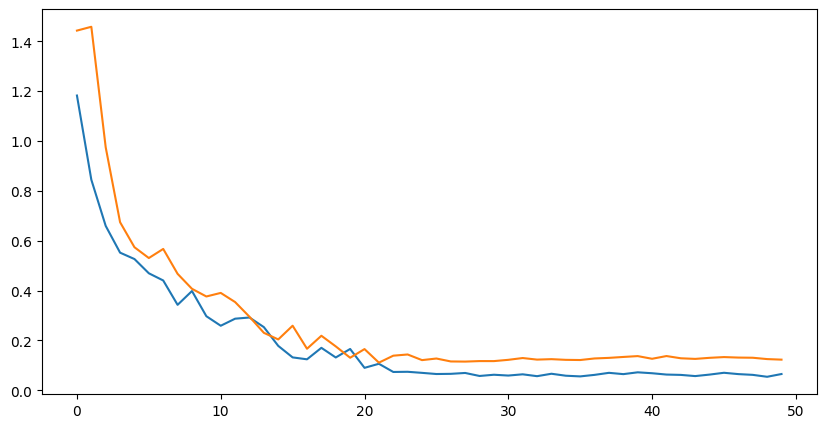

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

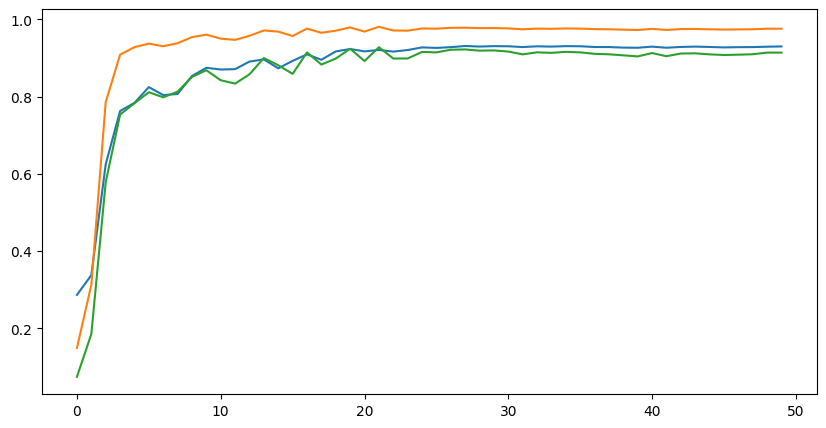

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)